In [1]:
import os
import twa
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from twa.utils import ensure_dir
from twa.train import VecTopoDataset, train_model_alt, predict_model

random.seed(2)
torch.manual_seed(2)

torch.use_deterministic_algorithms(True) 
%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_lattice = 64

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


# Classify point vs cycle attractor

In [2]:
# training configuration
outdir = '../output/'
data_dir = os.path.join(outdir, 'data') 
dim = 2
batch_size = 64

train_data_descs = ['simple_oscillator_nsfcl']

train_data_desc_ = '_'.join(train_data_descs)

kwargs_train = {}

with_attention = True 
datatype = 'angle'
model_type = None

save = False; save_dir = None

with_attention_str = 'atten' if with_attention else 'noatten'
if model_type is None:
    exp_desc = train_data_desc_ + '_' + datatype + '_' + with_attention_str
else:
    exp_desc = train_data_desc_ + '_' + datatype + '_' + model_type

datasize = 10000

11944


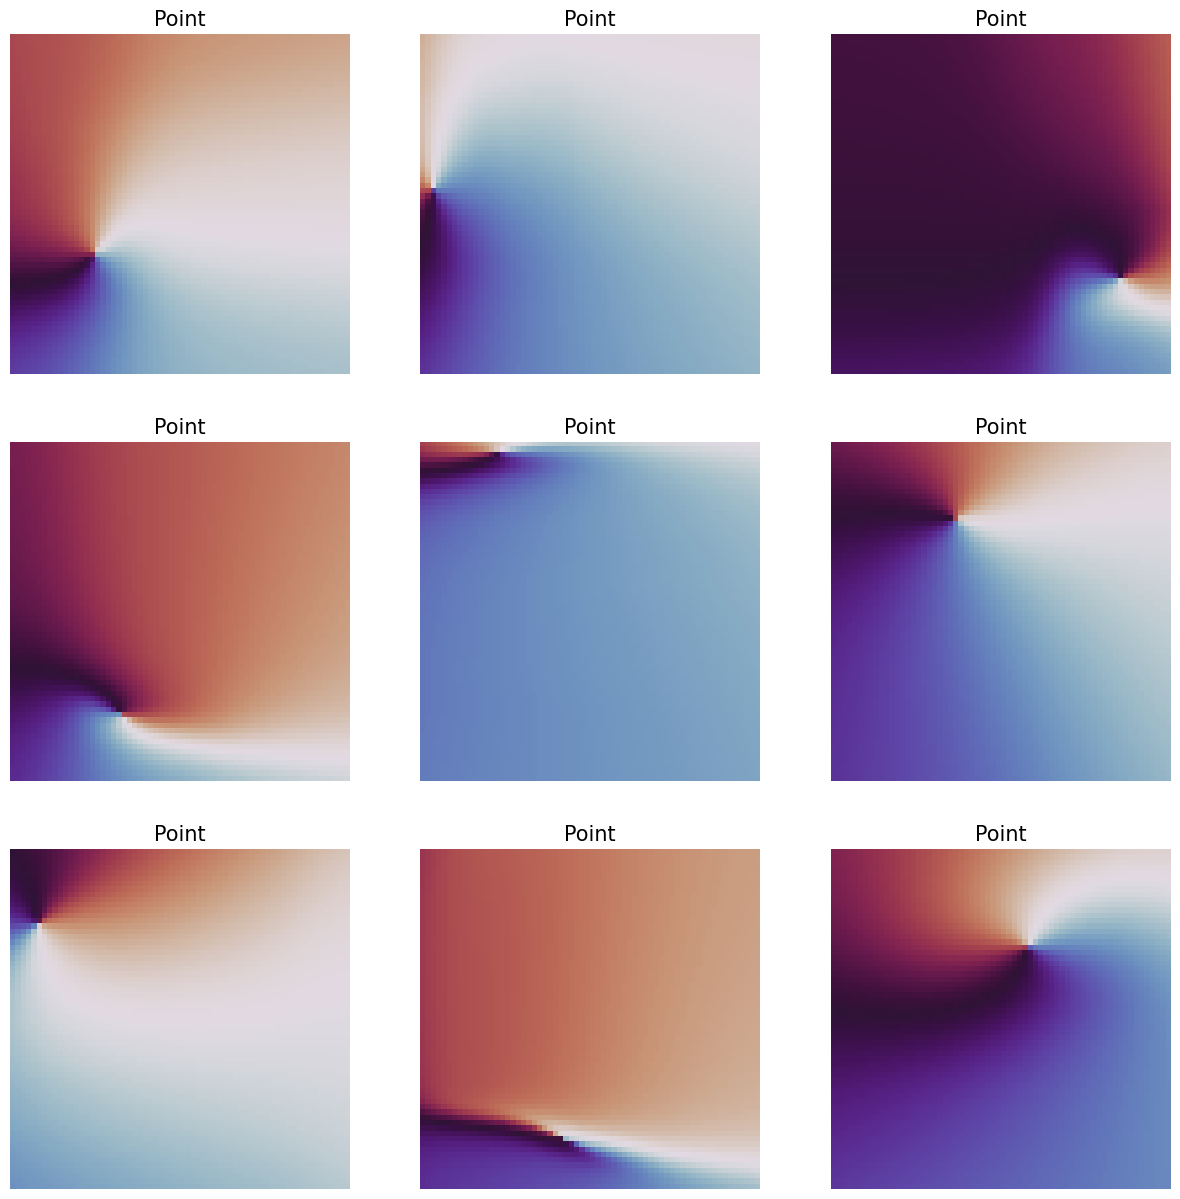

In [3]:
# combine train datasets in case multiple are given
for itrain_data_desc, train_data_desc in enumerate(train_data_descs):
    train_data_dir = os.path.join(data_dir, train_data_desc)
    if itrain_data_desc == 0:
        train_dataset = VecTopoDataset(train_data_dir, datatype=datatype, datasize=datasize, filter_outbound=True)
        train_dataset.plot_data()
    else:
        train_dataset += VecTopoDataset(train_data_dir, datatype=datatype, datasize=datasize, filter_outbound=True)
        
    

In [4]:
# train
model, losses = train_model_alt(train_dataset, model_type=model_type, with_attention=with_attention, device=device, verbose=True)

Training classifier...
Training data size: 10000
Loading...
Training...
Train Epoch: 0 [0/10000 (0%)]	Loss: 0.691391
Train Epoch: 0 [128/10000 (0%)]	Loss: 0.695567
Train Epoch: 0 [256/10000 (0%)]	Loss: 0.692172
Train Epoch: 0 [384/10000 (0%)]	Loss: 0.694574
Train Epoch: 0 [512/10000 (0%)]	Loss: 0.693930
Train Epoch: 0 [640/10000 (0%)]	Loss: 0.691946
Train Epoch: 0 [768/10000 (0%)]	Loss: 0.695192
Train Epoch: 0 [896/10000 (0%)]	Loss: 0.689620
Train Epoch: 0 [1024/10000 (0%)]	Loss: 0.683207
Train Epoch: 0 [1152/10000 (0%)]	Loss: 0.693059
Train Epoch: 0 [1280/10000 (0%)]	Loss: 0.691869
Train Epoch: 0 [1408/10000 (0%)]	Loss: 0.695506
Train Epoch: 0 [1536/10000 (0%)]	Loss: 0.696854
Train Epoch: 0 [1664/10000 (0%)]	Loss: 0.681219
Train Epoch: 0 [1792/10000 (0%)]	Loss: 0.690394
Train Epoch: 0 [1920/10000 (0%)]	Loss: 0.679864
Train Epoch: 0 [2048/10000 (0%)]	Loss: 0.685596
Train Epoch: 0 [2176/10000 (0%)]	Loss: 0.692247
Train Epoch: 0 [2304/10000 (0%)]	Loss: 0.704127
Train Epoch: 0 [2432/10000

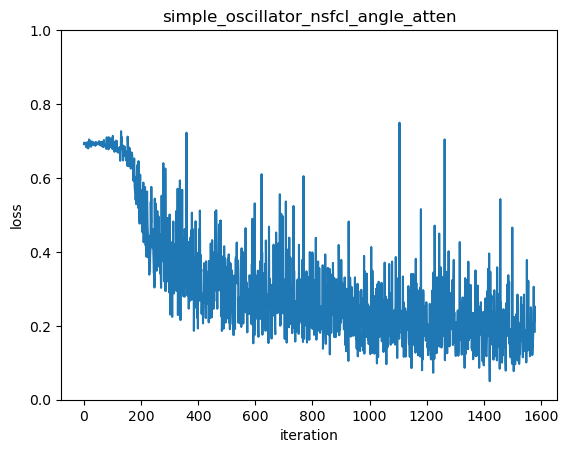

In [5]:
# plot train loss
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title(exp_desc)
plt.ylim(0, 1)
plt.show()

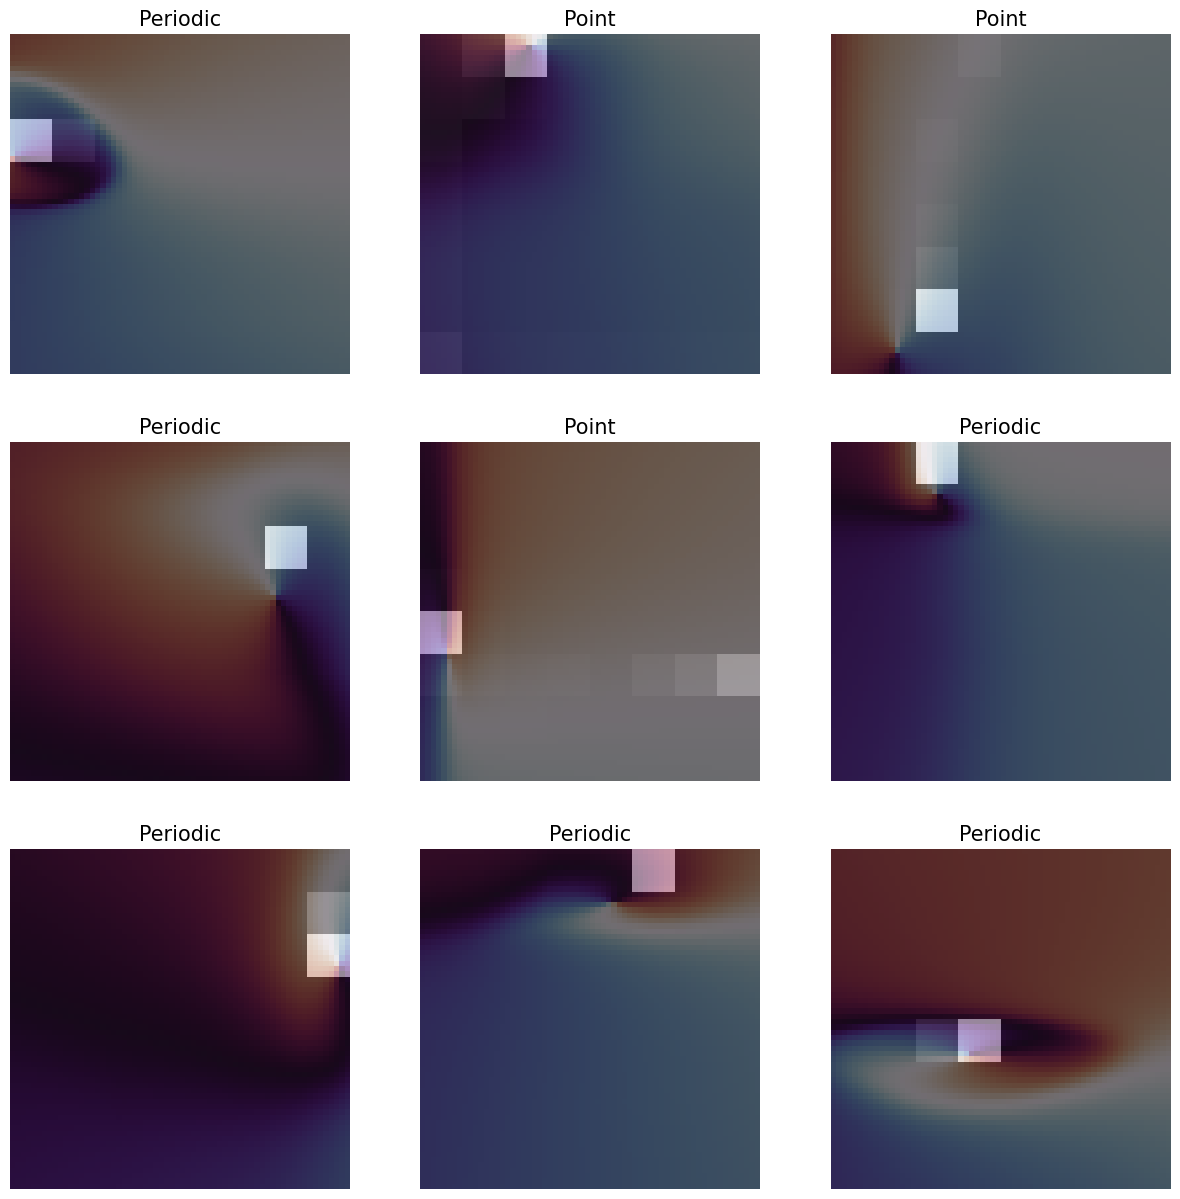

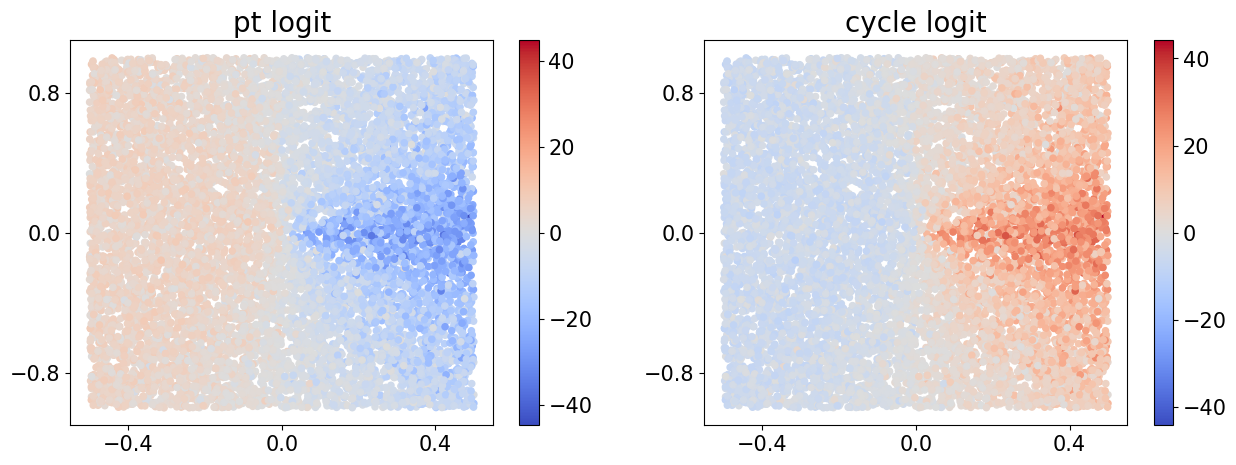

In [6]:
# visualize train results
# plot examples of attention masks
model.plot_attention(train_dataset, n_samples=9)


correct, auc, output = predict_model(model, train_dataset)
fig, ax = plt.subplots(1,2, figsize=(15,5))
sysp = train_dataset.sysp

twa.utils.plot_diverge_scale(sysp[:,0], sysp[:,1], output[:,0], ax=ax[0], title='pt logit')
twa.utils.plot_diverge_scale(sysp[:,0], sysp[:,1], output[:,1], ax=ax[1], title='cycle logit')

plt.show()

# Examine test data

## Accuracy

In [7]:

results_dir = os.path.join(outdir, 'results')
exp_results_dir = os.path.join(results_dir, exp_desc)
ensure_dir(exp_results_dir)

test_data_descs = [
    'simple_oscillator_noaug',
    'simple_oscillator_nsfcl',
    'suphopf',
    'subhopf',
    'lienard_poly',
    'lienard_sigmoid',
    'vanderpol',
    'bzreaction',
    'selkov',
    'selkov2',
    'repressilator',
    'pancreas_clusters_random_bin',
]


tt = 'test'
res = []
for test_data_desc in test_data_descs:
    print(test_data_desc)
    test_data_dir = os.path.join(data_dir, test_data_desc)
    if os.path.isdir(test_data_dir):
        test_dataset = VecTopoDataset(test_data_dir,  tt=tt, datatype=datatype) 

        if save:
            save_dir = os.path.join(exp_results_dir, test_data_desc)
            ensure_dir(save_dir)

        correct, auc, _ = predict_model(model, test_dataset, verbose=False, save=save, save_dir=save_dir)
        res.append({'data': os.path.basename(test_data_dir),
                    'correct': correct,
                    'auc': auc})

pd.DataFrame(res)

simple_oscillator_noaug
1000
simple_oscillator_nsfcl
1100
suphopf
1000
subhopf
1000
lienard_poly
1000
lienard_sigmoid
1000
vanderpol
1000
bzreaction
1000
selkov
1000
selkov2
1000
repressilator
3000
pancreas_clusters_random_bin
69


,data,correct,auc
0,simple_oscillator_noaug,0.990000,0.999448
1,simple_oscillator_nsfcl,0.928182,0.976691
2,suphopf,0.985000,0.999435
3,subhopf,0.498000,0.818200
4,lienard_poly,0.880000,0.999944
5,lienard_sigmoid,0.903000,0.997031
6,vanderpol,0.861000,0.987630
7,bzreaction,0.924000,0.988408
8,selkov,0.609000,0.679106
9,selkov2,0.638000,0.739697


1000


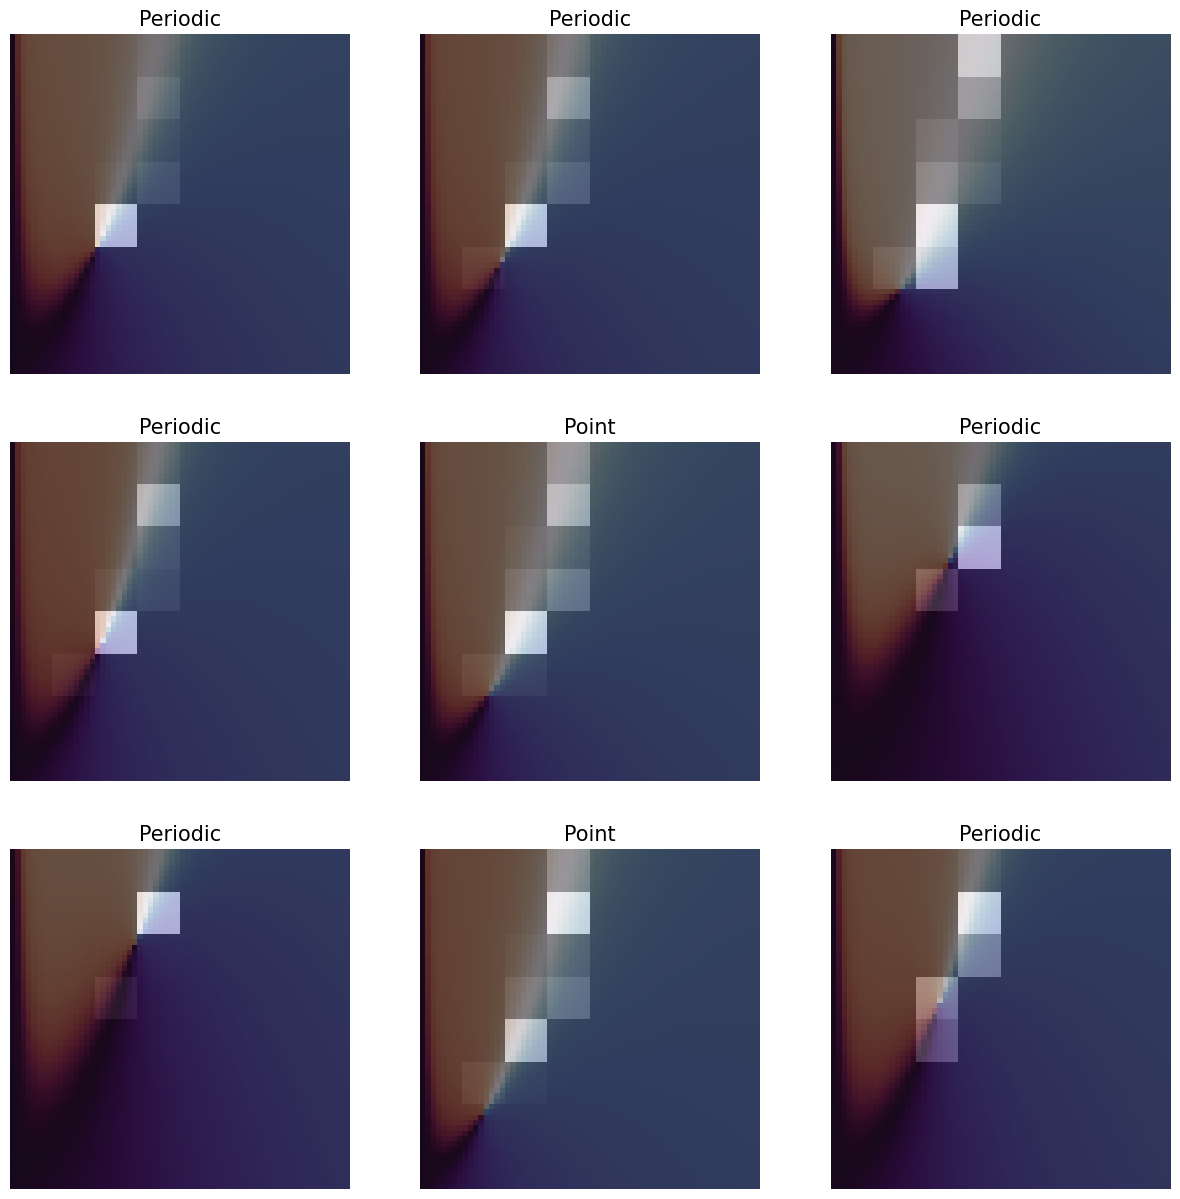

In [8]:
# example, 
test_data_desc = 'bzreaction'
test_data_dir = os.path.join(data_dir, test_data_desc)
test_dataset = VecTopoDataset(test_data_dir,  tt=tt, datatype=datatype) 
model.plot_attention(test_dataset, n_samples=9)


1100
simple_oscillator_nsfcl, with Gaussian noise of scale 0.5, 0.72 correct, 0.93 auc


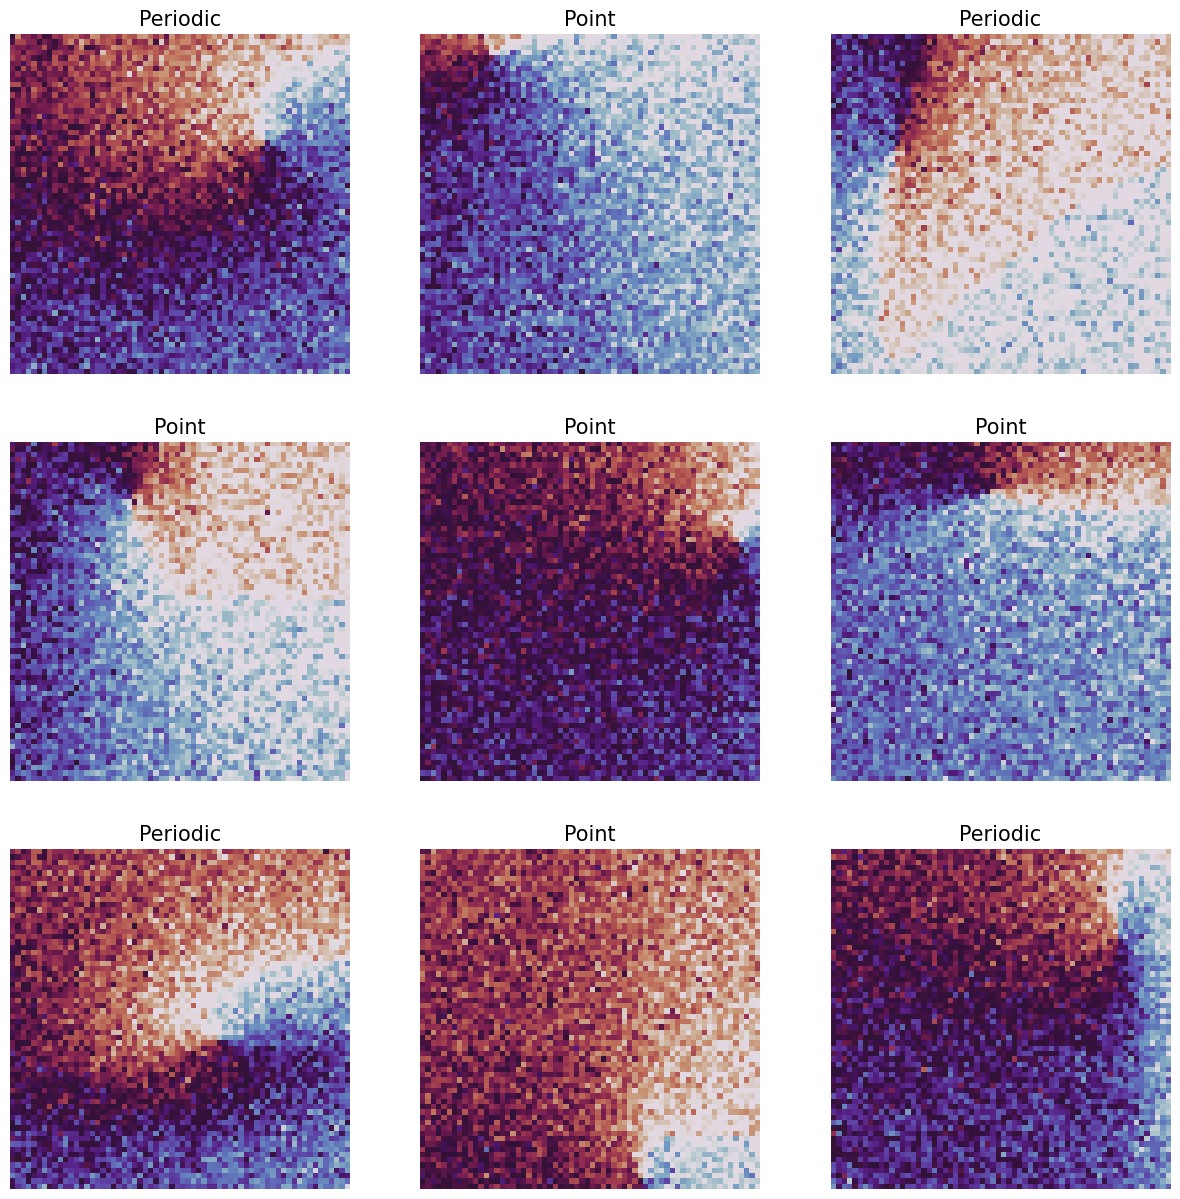

In [9]:
# test with noise
tt = 'test'
noise = 0.5
test_data_dir = os.path.join(data_dir, train_data_desc_)
test_data_desc = train_data_desc_ + '_noise%.2f' % noise
test_dataset = VecTopoDataset(test_data_dir,  tt=tt, datatype=datatype, noise=noise) 

if save:
    save_dir = os.path.join(exp_results_dir, test_data_desc)
    ensure_dir(save_dir)

correct, auc, _ = predict_model(model, test_dataset, verbose=False, save=save, save_dir=save_dir)
print(f'{train_data_desc_}, with Gaussian noise of scale {noise}, {correct:.2f} correct, {auc:.2f} auc')

test_dataset.plot_data()


In [10]:
if save:
    models_dir = os.path.join(outdir, 'models')
    ensure_dir(models_dir)
    torch.save(model.state_dict(), os.path.join(models_dir, f'{exp_desc}.pt'))